## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

In [3]:
DATASETS_FOLDER = "C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Final_Outputs/"
IMAGES_OUTPUT_FOLDER = "C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Own Papers/Undergraduate Paper/Images/"

## Defining Analysis Functions

In [4]:
def import_data(model_name="univariate_baseline"):
    true = np.squeeze(np.load(DATASETS_FOLDER+model_name+"_true_y.npy"))
    predicted = np.load(DATASETS_FOLDER+model_name+"_predicted_y.npy")
    return true, predicted

In [5]:
def compute_residuals(true, pred):
    residuals = np.sum(true-pred, axis=1)
    residuals = ((residuals)/true.shape[1])/ 1000
    return residuals

In [6]:
def generate_boxplot(datasets=[],title="DEFAULT", ylab="Residuals (Mbps)",xlab=[], colours=[],
                      output_folder=IMAGES_OUTPUT_FOLDER, ylim=()):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_ylabel(ylab)
    box = ax.boxplot(datasets, whis=(5,95), patch_artist=True, notch=True, flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'fuchsia'})
    ax.set_xticklabels(xlab)
    if colours:
        for bplot, colour in zip(box["boxes"], colours):
            bplot.set_color(colour)
    if ylim:
        ax.set_ylim(ylim)
    ax.yaxis.grid(True)
    plt.xticks(rotation=-45)
    plt.savefig(output_folder+title+".png", dpi=320)

In [7]:
def get_variance(data):
    return np.var(data)

In [8]:
def get_std(data):
    return np.std(data)

In [9]:
def get_ts_residuals(true, pred):
        residuals = true-pred
        residuals = residuals / 1000
        return residuals

In [20]:
import seaborn as sns
def time_step_boxplots(residuals=[], model_names=[], title="", xlim=(), savefig_path="", xlab="Residuals (Mb)",showfliers = True):
    df = pd.DataFrame()
    for model, residuals in zip(model_names, residuals):
        for i in range(residuals.shape[1]):
            temp_df = pd.DataFrame()
            temp_df[xlab] = residuals[:,i]
            temp_df["Horizon (seconds)"] = i+1
            temp_df["Model"] = model
            df = pd.concat([df, temp_df])
    sns.set_theme(style="whitegrid")
    if showfliers:
        box = sns.boxplot(x=xlab, y="Horizon (seconds)",
                    hue="Model",
                    data=df, orient="h", whis=(5,95), saturation=1, flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'pink'})
    else:
        box = sns.boxplot(x=xlab, y="Horizon (seconds)",
            hue="Model",
            data=df, orient="h", whis=(5,95), saturation=1, showfliers=False)
    if xlim:
        box.set_xlim(xlim)
    box.set_title(title)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    # box.set_ylabel("Horizon (seconds)")
    if savefig_path:
        plt.savefig(savefig_path, dpi=300, bbox_inches='tight')
    
    plt.show() # Display the plot on the screen
    

In [11]:
def get_mape(true, predicted, epsilon=50):
    denominator = np.squeeze(true) + epsilon
    try:
        mape = np.mean(np.abs((np.squeeze(true) - predicted)/denominator))*100
    except Exception as e:
        print(e)
        mape = "n/a"
    return mape

In [12]:
def get_ape(true, predicted, epsilon=50):
    denominator = np.squeeze(true) + epsilon
    try:
        ape = np.abs((np.squeeze(true) - predicted)/denominator)*100
    except Exception as e:
        print(e)
        ape = "n/a"
    return ape

In [13]:
def get_mse(true, predicted):
    mse = np.mean(np.power(np.squeeze(true)-predicted, 2))
    return mse

In [14]:
def get_mae(true, predicted):
    mae = np.mean(np.abs(np.squeeze(true)-predicted))
    return mae

In [22]:
def carry_out_analysis(prefix="univariate", title_prefix="Univariate"):
    for dataset in ["low", "medium", "high", 1]:
        if dataset == 1:
            base_true, base_pred = import_data(model_name="{}_baseline".format(prefix))
            multiOne_true, multiOne_pred = import_data(model_name="{}_multiOne".format(prefix))
            multiAll_true, multiAll_pred = import_data(model_name="{}_multiAll".format(prefix))

            # Get Residuals
            base_resids = get_ts_residuals(base_true, base_pred)
            multiOne_resids = get_ts_residuals(multiOne_true, multiOne_pred)
            multiAll_resids = get_ts_residuals(multiAll_true, multiAll_pred)


            # Get Absolute Percent Error
            base_ape = get_ape(base_true, base_pred)
            multiOne_ape = get_ape(multiOne_true, multiOne_pred)
            multiAll_ape = get_ape(multiAll_true, multiAll_pred)
            
            # Boxplot of residuals
            time_step_boxplots(residuals=[base_resids, multiOne_resids, multiAll_resids],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Model Performance on All Test Sequences",
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"{} On All Test Data".format(title_prefix))
            
            # Boxplot of Absolute Percent Error
            time_step_boxplots(residuals=[base_ape, multiOne_ape, multiAll_ape],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Absolute Percent Error on All Test Sequences",
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"APE of {} On All Test Data".format(title_prefix), xlab="Absolute Percent Error")
            
            # Boxplot of residuals No outliers
            time_step_boxplots(residuals=[base_resids, multiOne_resids, multiAll_resids],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Model Performance on All Test Sequences",
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"{} On All Test Data no Outliers".format(title_prefix), showfliers = False)
            
            # Boxplot of Absolute Percent Error no Outliers
            time_step_boxplots(residuals=[base_ape, multiOne_ape, multiAll_ape],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Absolute Percent Error on All Test Sequences",
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"APE of {} On All Test Data no Outliers".format(title_prefix), xlab="Absolute Percent Error", showfliers = False)


            # Standard Dev
            base_std = get_std(base_resids)
            multiOne_std = get_std(multiOne_resids)
            multiAll_std = get_std(multiAll_resids)

            # MAPE
            base_mape = get_mape(base_true, base_pred)
            multiOne_mape = get_mape(multiOne_true, multiOne_pred)
            multiAll_mape = get_mape(multiAll_true, multiAll_pred)

            # MSE
            base_mse = get_mse(base_true, base_pred)
            multiOne_mse = get_mse(multiOne_true, multiOne_pred)
            multiAll_mse = get_mse(multiAll_true, multiAll_pred)

            # MAE
            base_mae = get_mae(base_true, base_pred)
            multiOne_mae = get_mae(multiOne_true, multiOne_pred)
            multiAll_mae = get_mae(multiAll_true, multiAll_pred)

            # Table of metrics
            table = PrettyTable(["Model", "Mean Resids (Mb)", " Resids std (Mb)", "MAPE", "MSE", "MAE"])
            table.add_row(["Baseline",np.mean(base_resids), base_std, base_mape, base_mse, base_mae])
            table.add_row(["Multistage One",np.mean(multiOne_resids), multiOne_std, multiOne_mape, multiOne_mse, multiOne_mae])
            table.add_row(["Multistage All",np.mean(multiAll_resids), multiAll_std, multiAll_mape, multiAll_mse, multiAll_mae])
            print("Residuals of All Sequences Test Set")
            print(table)
            
        else:
            base_true, base_pred = import_data(model_name="{}_baseline_{}".format(prefix, dataset))
            single_true, single_pred = import_data(model_name="{}_multiOne_{}".format(prefix, dataset))

            # Get Residuals
            base_resids = get_ts_residuals(base_true, base_pred)
            single_resids = get_ts_residuals(single_true, single_pred)

            # Get APE
            base_ape = get_ape(base_true, base_pred)
            single_ape = get_ape(single_true, single_pred)
            
            # Boxplot of residuals
            time_step_boxplots(residuals=[base_resids, single_resids],
                                model_names=["Baseline", "{} Only".format(dataset)],
                                  title="Model Performance on {} Test Sequences".format(dataset),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"{} On {} Test Set".format(title_prefix, dataset))

            # Boxplot of APE
            time_step_boxplots(residuals=[base_ape, single_ape],
                                model_names=["Baseline", "{} Only".format(dataset)],
                                  title="Absolute Percent Error on {} Test Sequences".format(dataset),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"APE of {} On {} Test Set".format(title_prefix, dataset), xlab="Absolute Percent Error")
            
            # Boxplot of residuals no Outliers
            time_step_boxplots(residuals=[base_resids, single_resids],
                                model_names=["Baseline", "{} Only".format(dataset)],
                                  title="Model Performance on {} Test Sequences".format(dataset),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"{} On {} Test Set no Outliers".format(title_prefix, dataset), showfliers = False)

            # Boxplot of APE no Outliers
            time_step_boxplots(residuals=[base_ape, single_ape],
                                model_names=["Baseline", "{} Only".format(dataset)],
                                  title="Absolute Percent Error on {} Test Sequences".format(dataset),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"APE of {} On {} Test Set no Outliers".format(title_prefix, dataset), xlab="Absolute Percent Error", showfliers = False)

            # Standard Dev
            base_std = get_std(base_resids)
            single_std = get_std(single_resids)

            # MAPE
            base_mape = get_mape(base_true, base_pred)
            single_mape = get_mape(single_true, single_pred)

            # MSE
            base_mse = get_mse(base_true, base_pred)
            single_mse = get_mse(single_true, single_pred)

            # MAE
            base_mae = get_mae(base_true, base_pred)
            single_mae = get_mae(single_true, single_pred)

            # Table of metrics
            table = PrettyTable(["Model", "Mean Resids (Mb)", " Resids std (Mb)", "MAPE", "MSE", "MAE"])
            table.add_row(["Baseline",np.mean(base_resids), base_std, base_mape, base_mse, base_mae])
            table.add_row(["{} Only".format(dataset),np.mean(single_resids), single_std, single_mape, single_mse, single_mae])
            print("Residuals of {} Sequences Test Set".format(dataset))
            print(table)
    true, pred = import_data(model_name="{}_multiOne_classifier".format(prefix))
    true = np.argmax(true, axis=-1)
    pred = np.argmax(pred, axis=-1)
    conf_matrix = confusion_matrix(true, pred)
    # create a dictionary to map class names
    class_names = {0: "low", 1: "medium", 2: "high"}

    # map the class names
    true_names = [class_names[x] for x in true]
    pred_names = [class_names[x] for x in pred]
    report = classification_report(true_names, pred_names, labels=["low", "medium", "high"])
    print("Classification Report:\n",report)
    display_conf = ConfusionMatrixDisplay(conf_matrix, display_labels=["Low", "Medium", "High"])
    display_conf.plot(cmap="Oranges")
    plt.show()

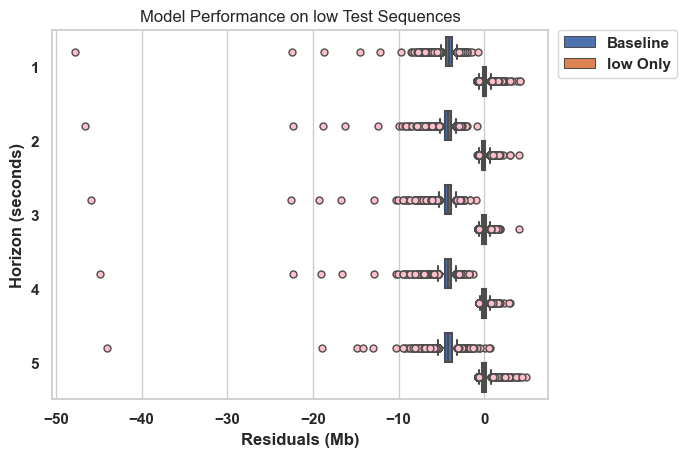

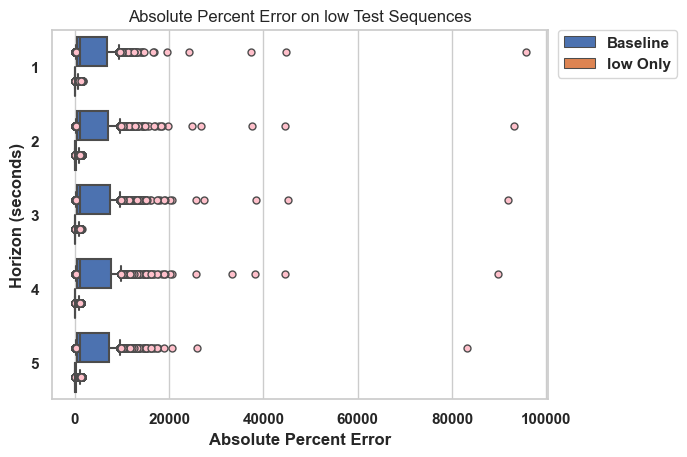

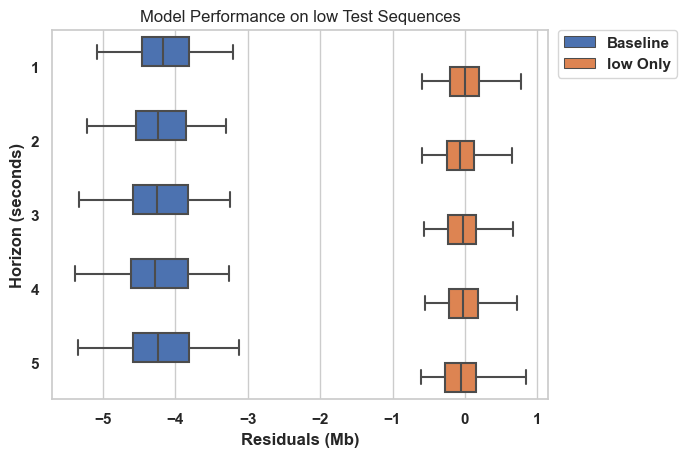

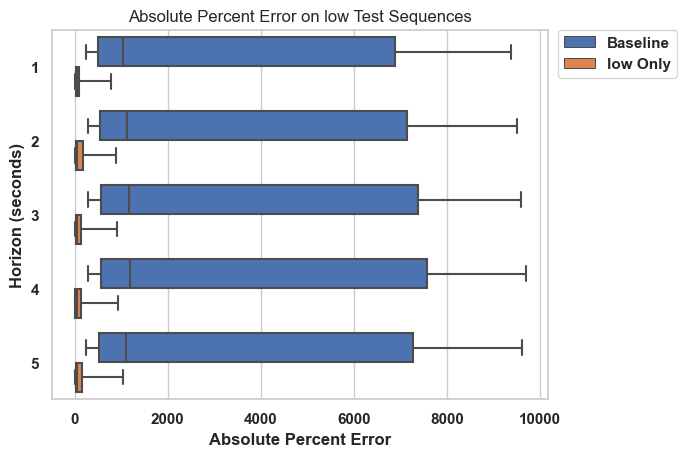

Residuals of low Sequences Test Set
+----------+-----------------------+---------------------+--------------------+--------------------+-------------------+
|  Model   |    Mean Resids (Mb)   |    Resids std (Mb)  |        MAPE        |        MSE         |        MAE        |
+----------+-----------------------+---------------------+--------------------+--------------------+-------------------+
| Baseline |   -4.252538167018816  |  1.0142689950947925 | 3250.7041668760485 | 19112822.456362344 | 4252.652979853169 |
| low Only | 6.179945827312149e-05 | 0.41199235665572387 | 164.95342862326072 | 169737.70576191024 | 285.8580453767101 |
+----------+-----------------------+---------------------+--------------------+--------------------+-------------------+


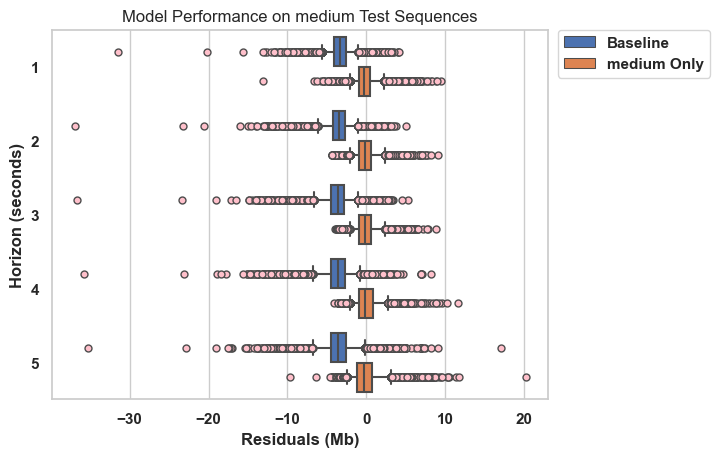

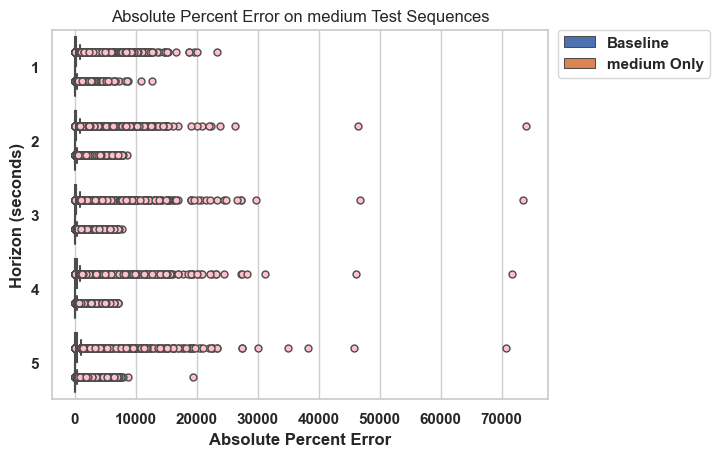

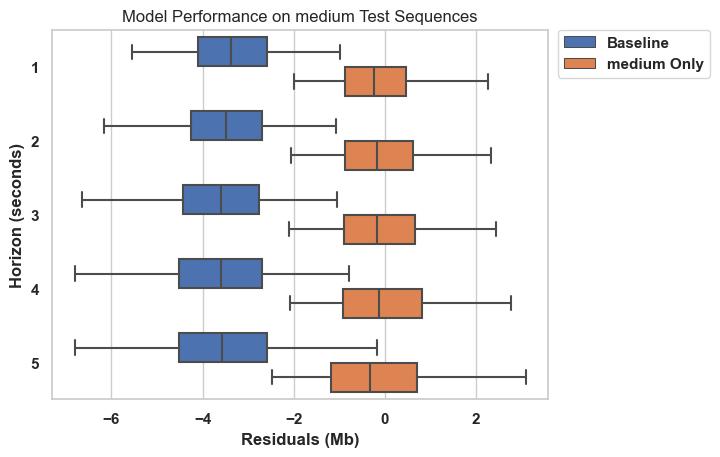

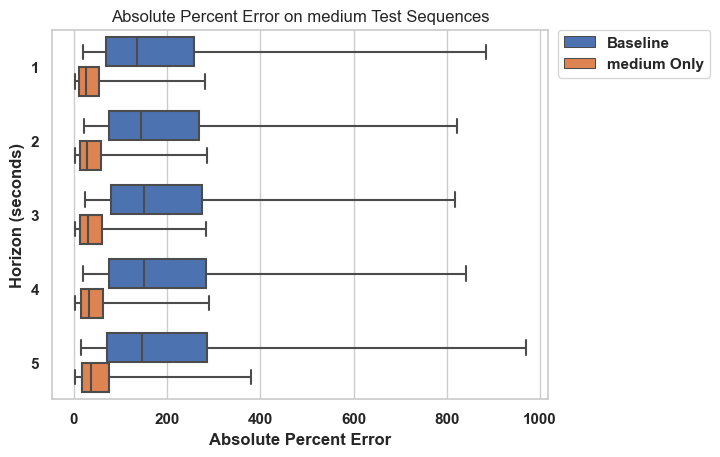

Residuals of medium Sequences Test Set
+-------------+-----------------------+--------------------+--------------------+--------------------+--------------------+
|    Model    |    Mean Resids (Mb)   |   Resids std (Mb)  |        MAPE        |        MSE         |        MAE         |
+-------------+-----------------------+--------------------+--------------------+--------------------+--------------------+
|   Baseline  |  -3.5652476398632675  | 1.8595463865314277 | 424.06526649859114 | 16168903.49721269  |  3626.32346207314  |
| medium Only | -0.059591838974032176 | 1.4733456983185265 | 133.10715130255687 | 2174298.7340260134 | 1085.7733698774732 |
+-------------+-----------------------+--------------------+--------------------+--------------------+--------------------+


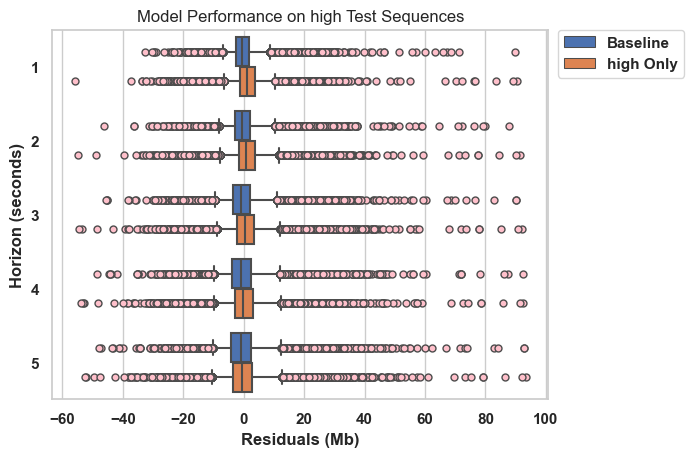

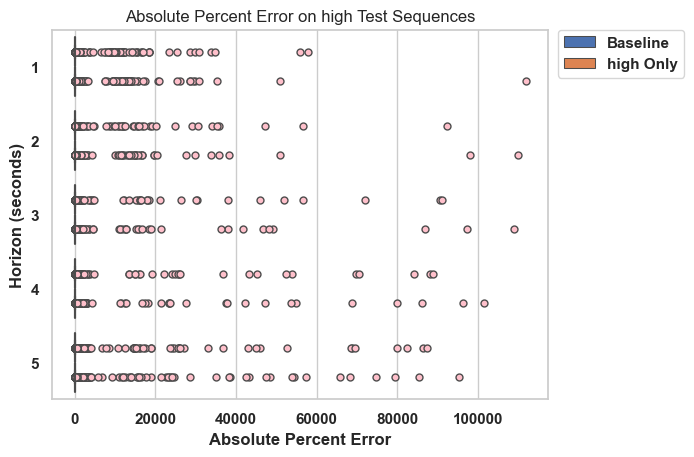

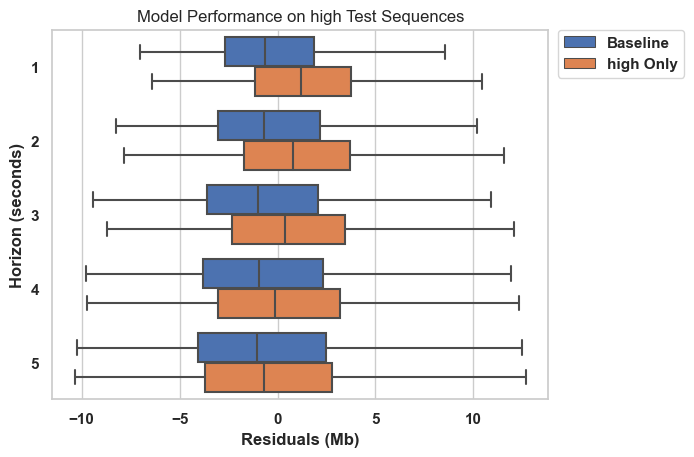

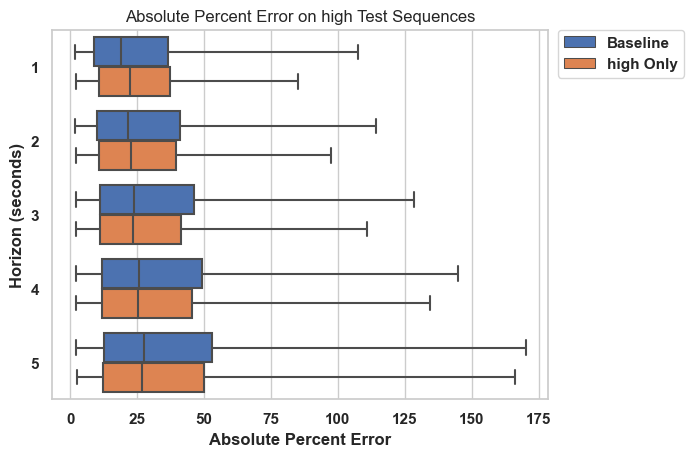

Residuals of high Sequences Test Set
+-----------+----------------------+-------------------+--------------------+--------------------+-------------------+
|   Model   |   Mean Resids (Mb)   |   Resids std (Mb) |        MAPE        |        MSE         |        MAE        |
+-----------+----------------------+-------------------+--------------------+--------------------+-------------------+
|  Baseline | -0.15994315607006288 |  6.83127050371585 | 103.33568269098143 | 46691838.508111864 | 4426.547220853669 |
| high Only |  0.8067181569226515  | 7.126612112623312 | 105.19998279674574 |  51439394.388498   | 4573.335291609981 |
+-----------+----------------------+-------------------+--------------------+--------------------+-------------------+


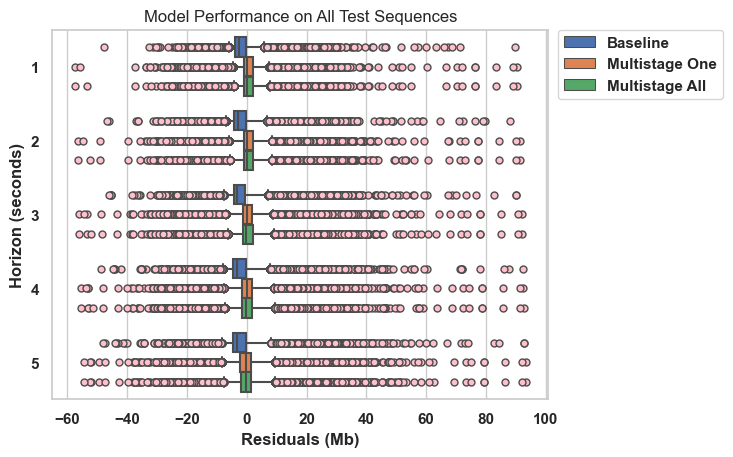

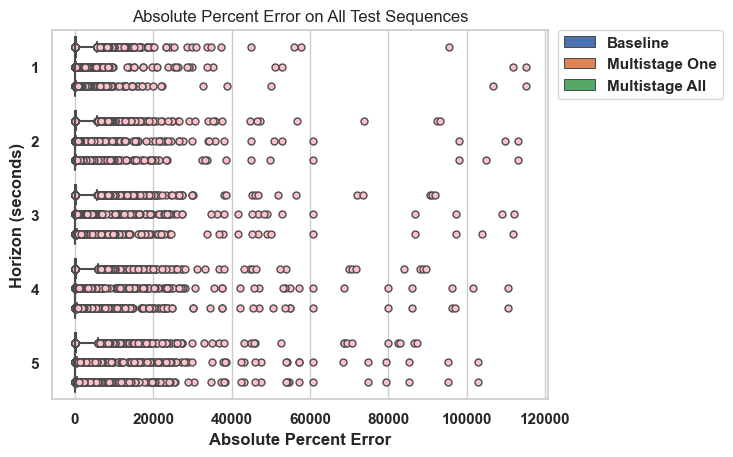

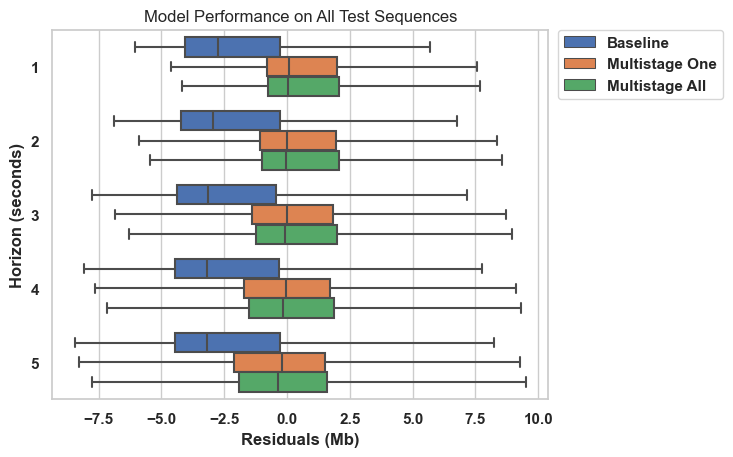

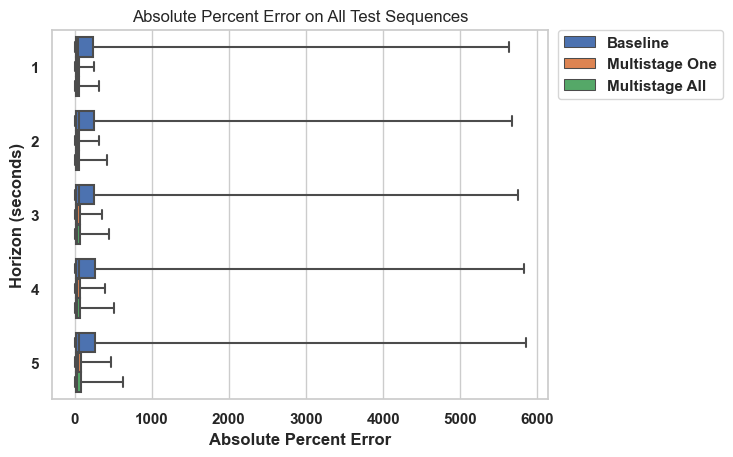

Residuals of All Sequences Test Set
+----------------+---------------------+-------------------+--------------------+--------------------+--------------------+
|     Model      |   Mean Resids (Mb)  |   Resids std (Mb) |        MAPE        |        MSE         |        MAE         |
+----------------+---------------------+-------------------+--------------------+--------------------+--------------------+
|    Baseline    | -1.8343086322671835 | 5.459279890756332 | 711.3792166373049  | 33168425.084026374 | 4161.543588662956  |
| Multistage One | 0.42632499469265817 |  5.55352007413317 | 176.44655438813308 | 31023338.214899782 | 3111.597993117481  |
| Multistage All |  0.5470724258147546 | 5.490278173972351 | 185.04929293250598 | 30442442.66668402  | 3061.7742658424604 |
+----------------+---------------------+-------------------+--------------------+--------------------+--------------------+
Classification Report:
               precision    recall  f1-score   support

         low     

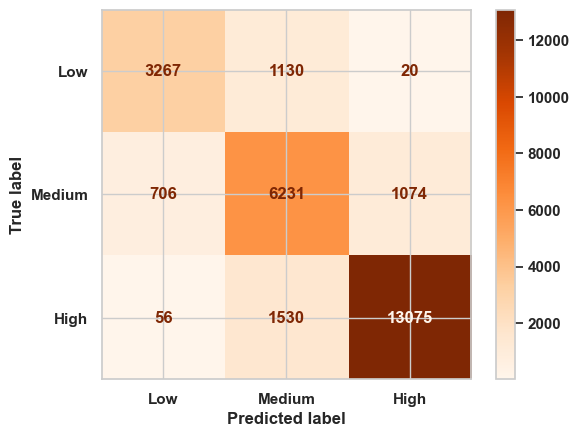

In [27]:
carry_out_analysis("pca_selected", "PCA Selected")

In [ ]:
carry_out_analysis("univariate", "Univariate")

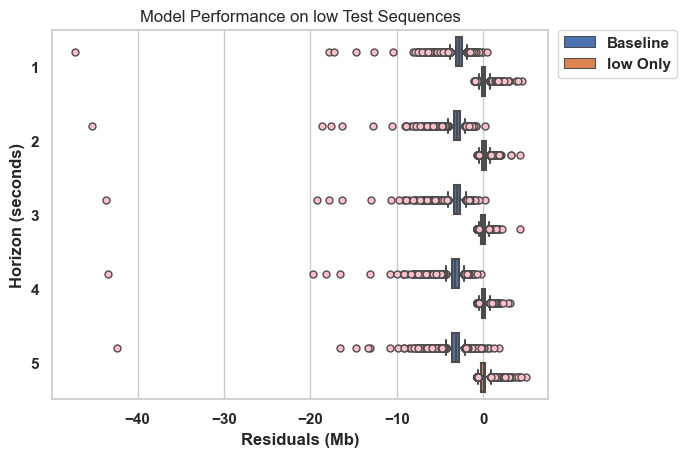

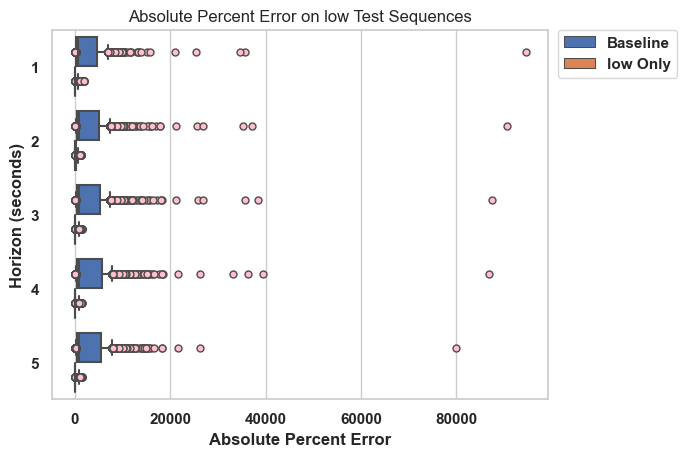

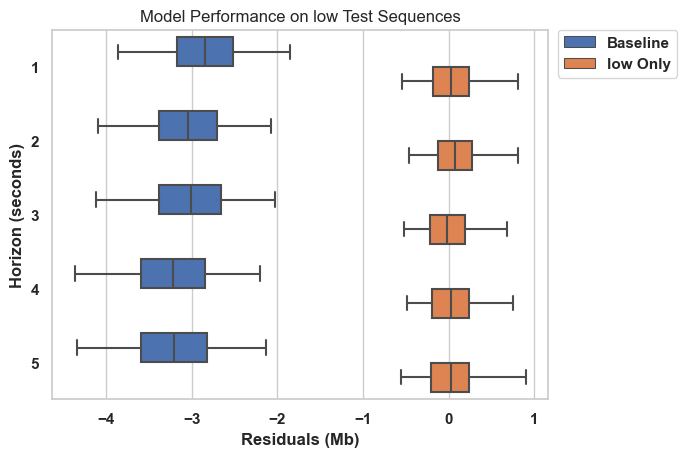

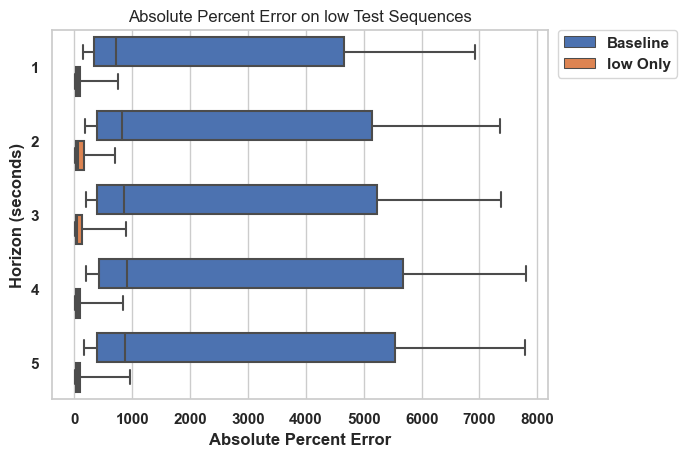

Residuals of low Sequences Test Set
+----------+---------------------+---------------------+--------------------+--------------------+--------------------+
|  Model   |   Mean Resids (Mb)  |    Resids std (Mb)  |        MAPE        |        MSE         |        MAE         |
+----------+---------------------+---------------------+--------------------+--------------------+--------------------+
| Baseline | -3.1172767181020604 |  1.0537041945695318 |  2425.5187180392   | 10827706.666874578 | 3117.8027288238122 |
| low Only | 0.06149421770483058 | 0.41599249360153967 | 152.32319379723262 | 176831.29354395613 | 288.9365159795542  |
+----------+---------------------+---------------------+--------------------+--------------------+--------------------+


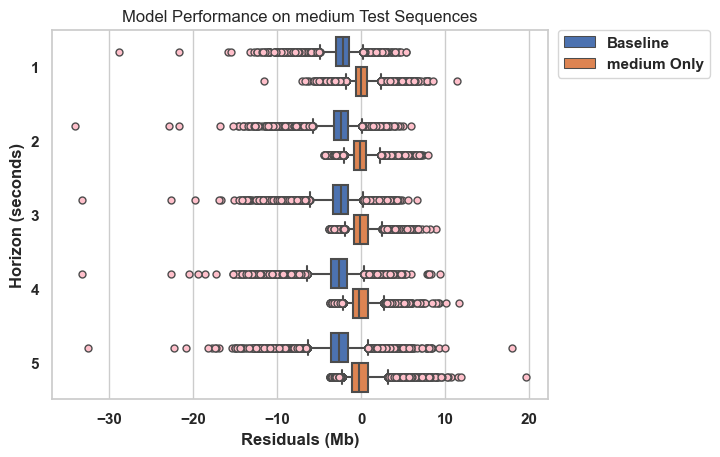

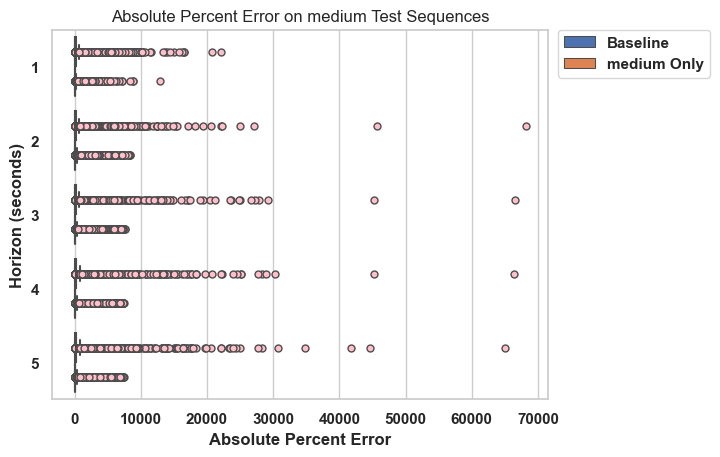

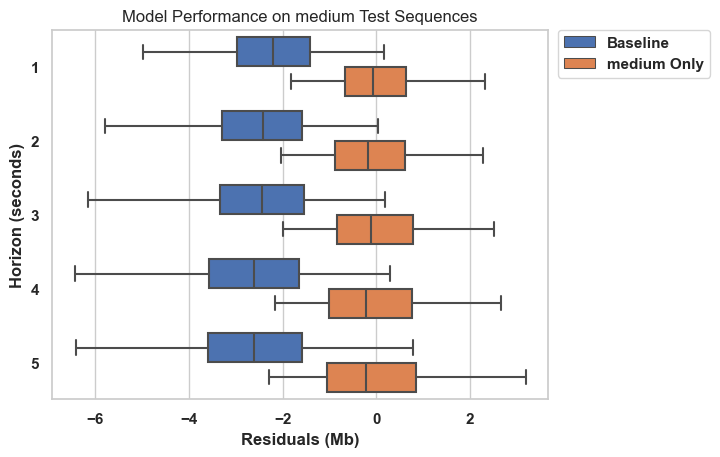

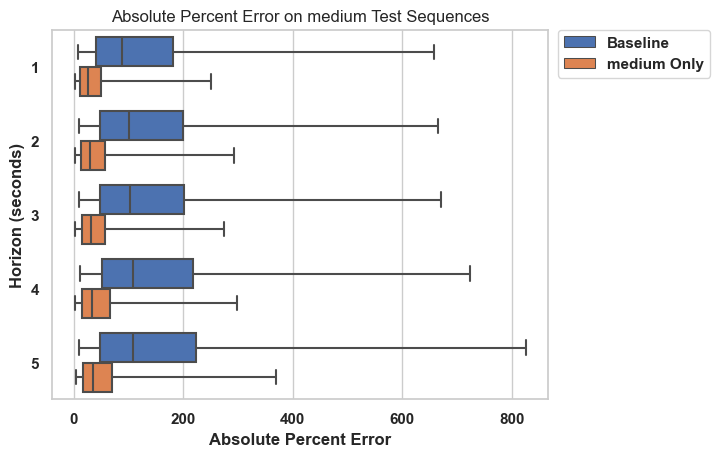

Residuals of medium Sequences Test Set
+-------------+------------------------+--------------------+--------------------+-------------------+--------------------+
|    Model    |    Mean Resids (Mb)    |   Resids std (Mb)  |        MAPE        |        MSE        |        MAE         |
+-------------+------------------------+--------------------+--------------------+-------------------+--------------------+
|   Baseline  |   -2.57862281745237    | 2.0533739473225556 | 342.73186981047775 | 10865640.20222901 | 2727.837567922257  |
| medium Only | -0.0005777127508790723 | 1.4620807414707224 | 132.06658040457668 |  2137680.4283316  | 1074.3740427811997 |
+-------------+------------------------+--------------------+--------------------+-------------------+--------------------+


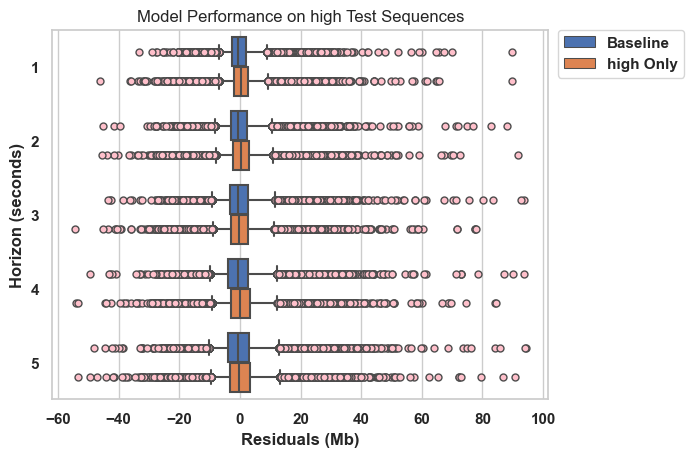

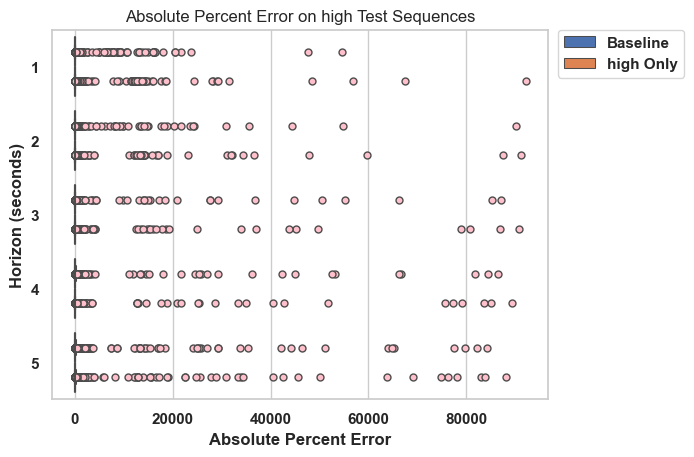

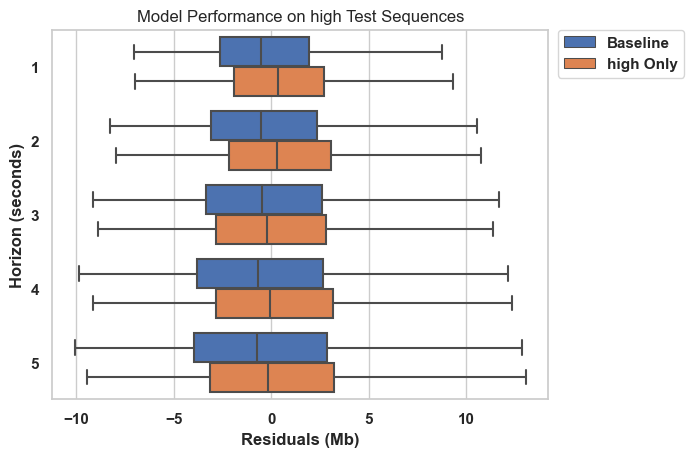

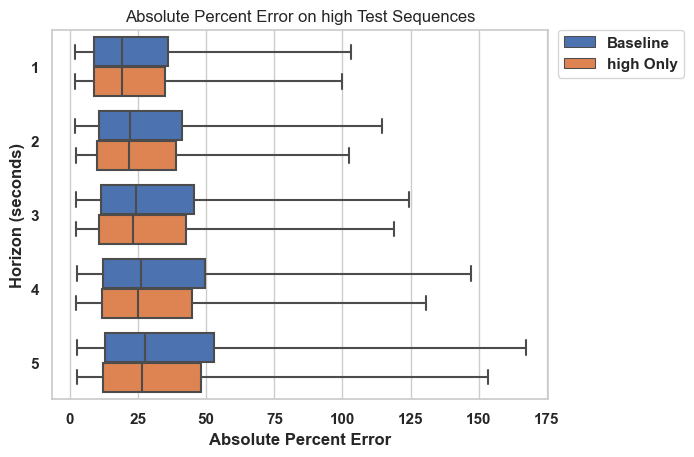

Residuals of high Sequences Test Set
+-----------+---------------------+--------------------+--------------------+-------------------+-------------------+
|   Model   |   Mean Resids (Mb)  |   Resids std (Mb)  |        MAPE        |        MSE        |        MAE        |
+-----------+---------------------+--------------------+--------------------+-------------------+-------------------+
|  Baseline | 0.05720539371328215 | 6.927918426993517  | 97.93651941561772  | 47999326.18814622 |  4495.53912210525 |
| high Only |  0.5475762936605909 | 6.9292450983718314 | 105.76974205707053 | 48314277.43068911 | 4409.781228577521 |
+-----------+---------------------+--------------------+--------------------+-------------------+-------------------+


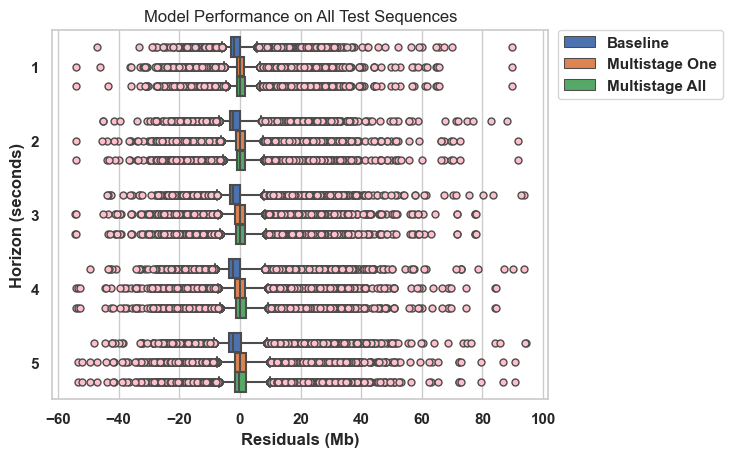

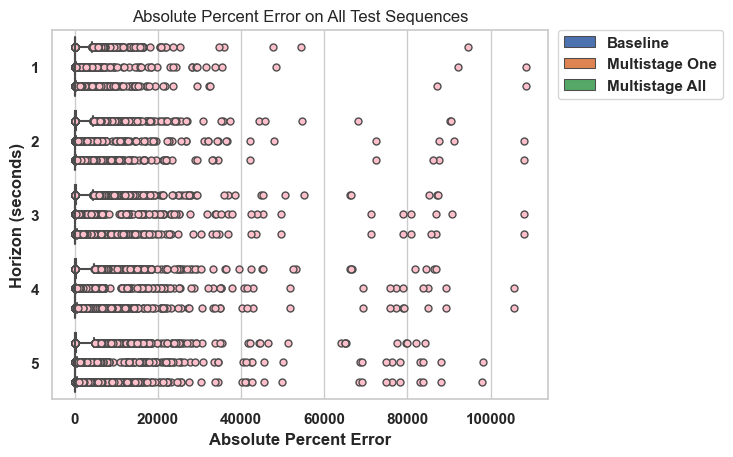

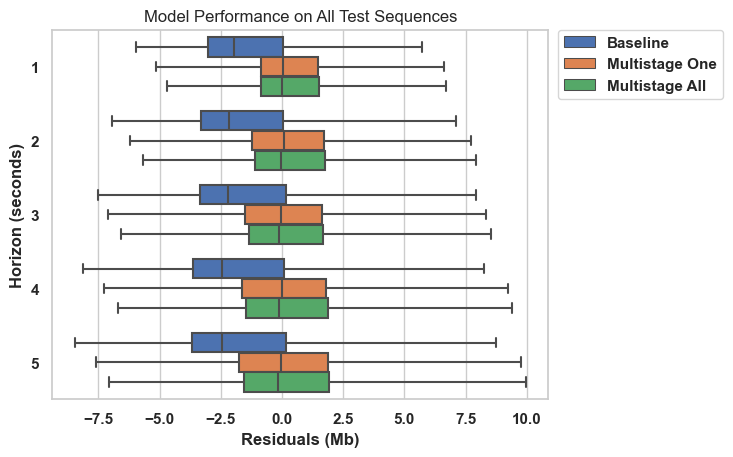

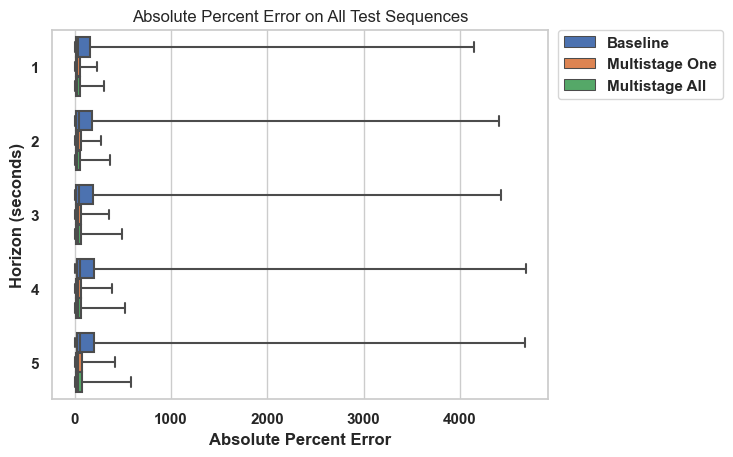

Residuals of All Sequences Test Set
+----------------+---------------------+-------------------+--------------------+--------------------+--------------------+
|     Model      |   Mean Resids (Mb)  |   Resids std (Mb) |        MAPE        |        MSE         |        MAE         |
+----------------+---------------------+-------------------+--------------------+--------------------+--------------------+
|    Baseline    | -1.2399007115665386 | 5.423969566553386 | 549.8537597655732  | 30956799.63344054  | 3748.1317316560853 |
| Multistage One | 0.38241243364834504 | 5.411809625837944 | 171.65120476463352 | 29433922.695721086 | 3028.722558255359  |
| Multistage All |  0.4836663817617593 | 5.356761570798119 | 181.16045781228013 | 28928827.695226047 | 2968.890152491508  |
+----------------+---------------------+-------------------+--------------------+--------------------+--------------------+
Classification Report:
               precision    recall  f1-score   support

         low     

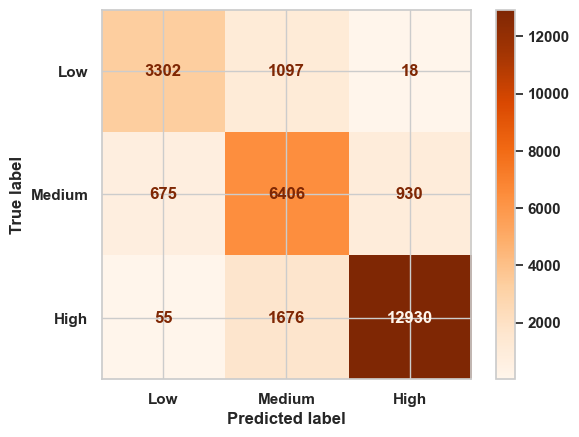

In [23]:
carry_out_analysis("with_upsampling", "Upsampling")

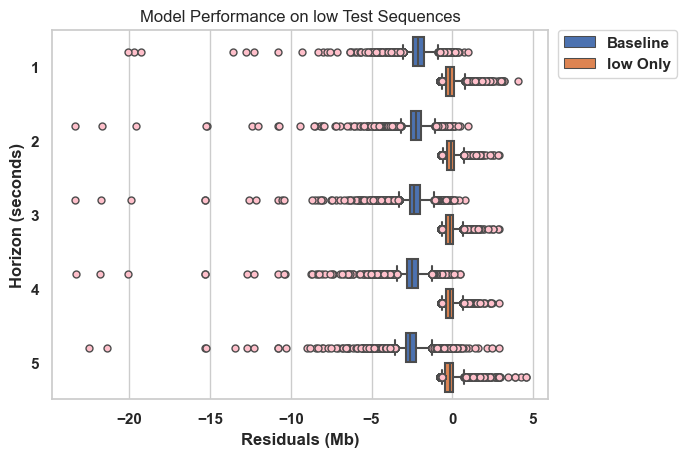

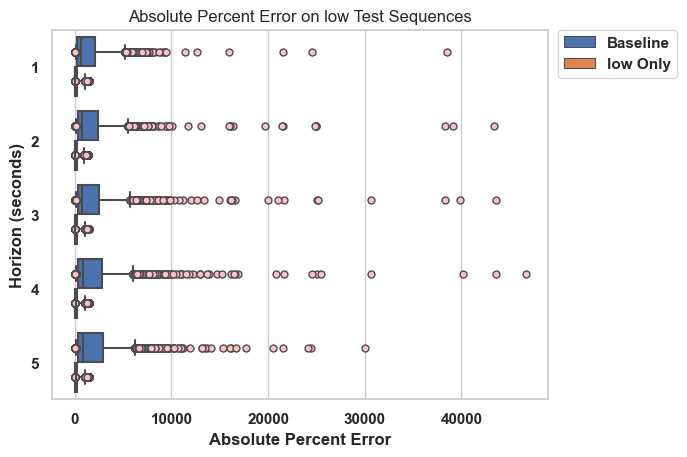

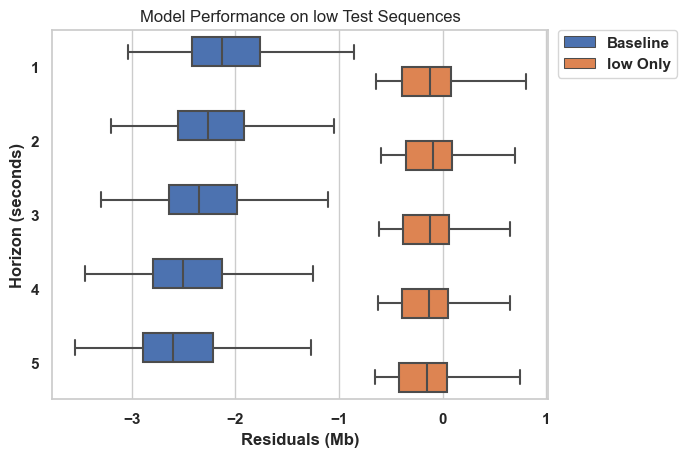

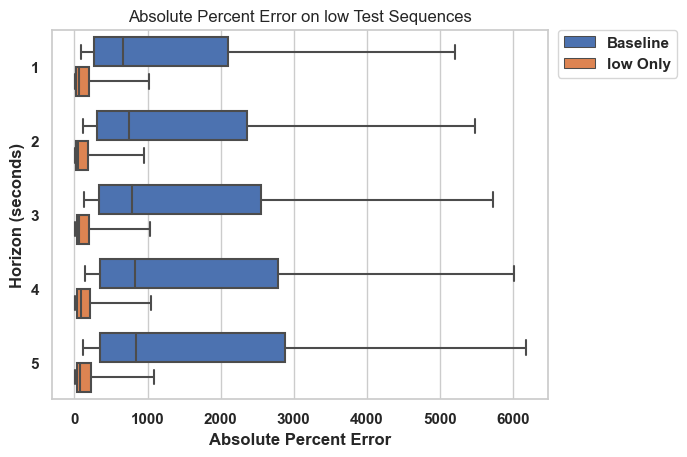

Residuals of low Sequences Test Set
+----------+----------------------+---------------------+--------------------+--------------------+--------------------+
|  Model   |   Mean Resids (Mb)   |    Resids std (Mb)  |        MAPE        |        MSE         |        MAE         |
+----------+----------------------+---------------------+--------------------+--------------------+--------------------+
| Baseline | -2.3453122037240353  |  0.9222644056697965 | 1784.3171836898762 | 6351060.966902355  | 2347.273260802495  |
| low Only | -0.08811906634230522 | 0.43278967166414867 | 211.58455452818973 | 195071.86975220116 | 328.91885774895474 |
+----------+----------------------+---------------------+--------------------+--------------------+--------------------+


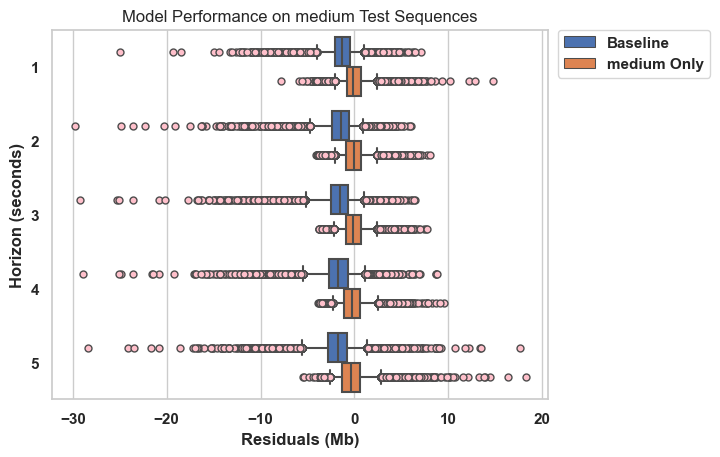

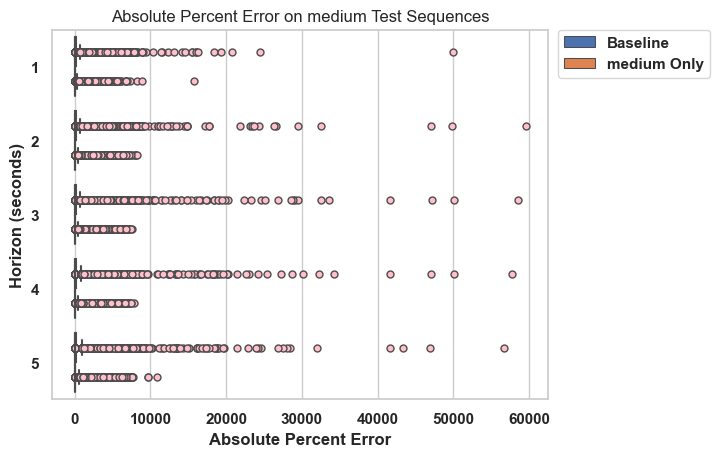

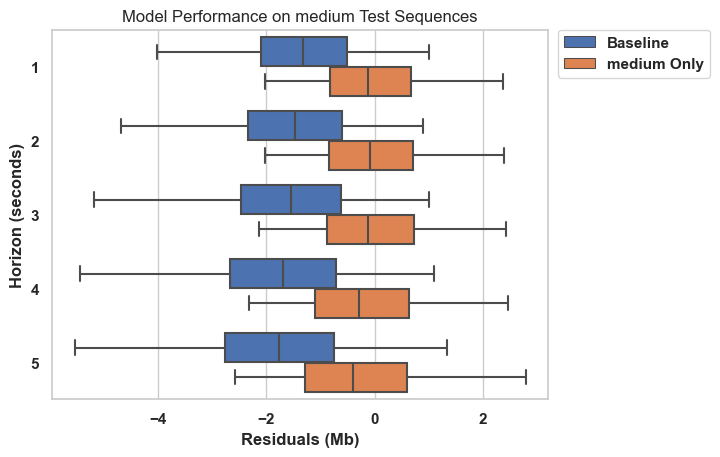

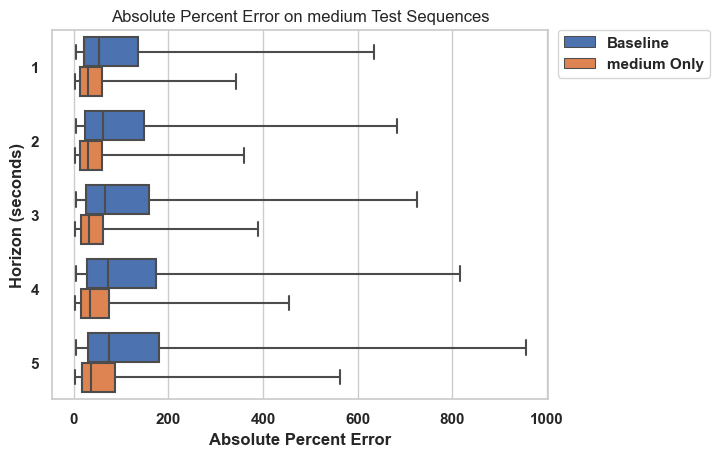

Residuals of medium Sequences Test Set
+-------------+----------------------+--------------------+--------------------+--------------------+--------------------+
|    Model    |   Mean Resids (Mb)   |   Resids std (Mb)  |        MAPE        |        MSE         |        MAE         |
+-------------+----------------------+--------------------+--------------------+--------------------+--------------------+
|   Baseline  | -1.6930174870953627  | 2.110410497212901  | 327.67954419351514 | 7320140.678357099  | 1999.6895427741606 |
| medium Only | -0.07141974780356466 | 1.4890751082505809 | 159.15141673986622 | 2222445.4583878038 | 1108.1554627207051 |
+-------------+----------------------+--------------------+--------------------+--------------------+--------------------+


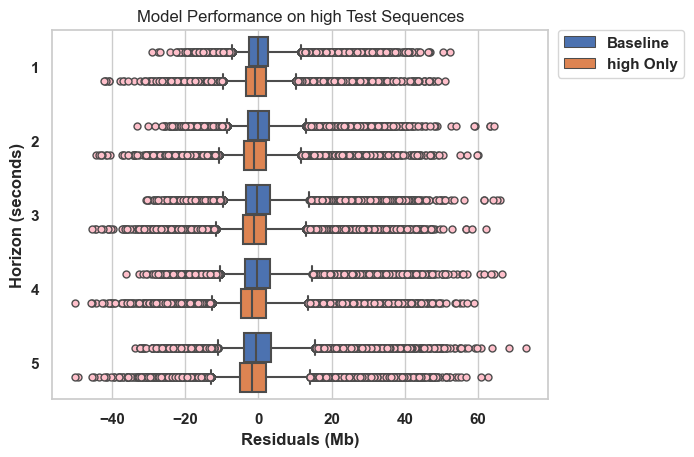

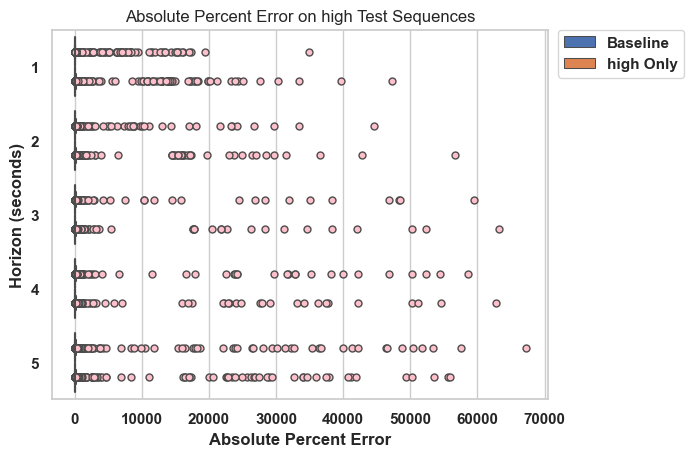

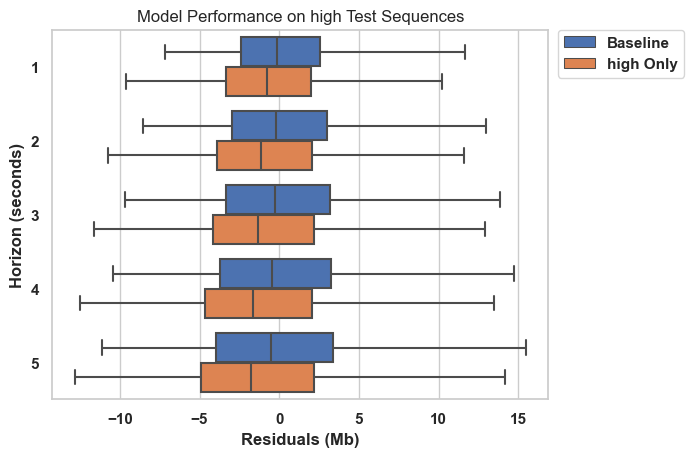

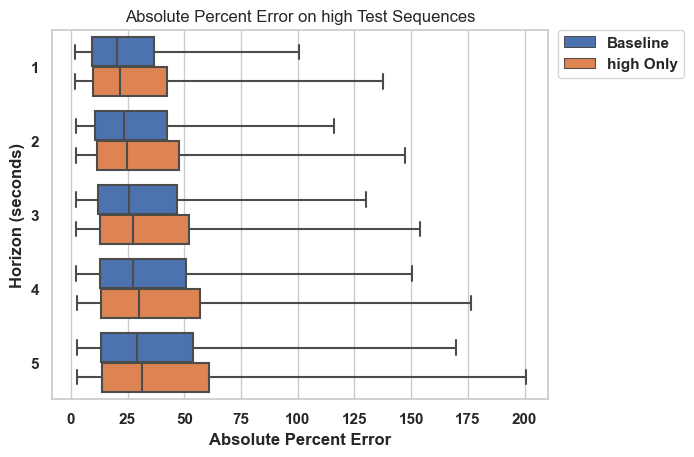

Residuals of high Sequences Test Set
+-----------+---------------------+-------------------+--------------------+--------------------+-------------------+
|   Model   |   Mean Resids (Mb)  |   Resids std (Mb) |        MAPE        |        MSE         |        MAE        |
+-----------+---------------------+-------------------+--------------------+--------------------+-------------------+
|  Baseline |  0.5885225107099049 | 7.711484970823114 | 88.48867104264752  | 59813359.20084306  | 4985.586132982542 |
| high Only | -0.6176597206985697 | 8.014203636713042 | 104.86464104283336 | 64608963.461277984 |  5289.33050454455 |
+-----------+---------------------+-------------------+--------------------+--------------------+-------------------+


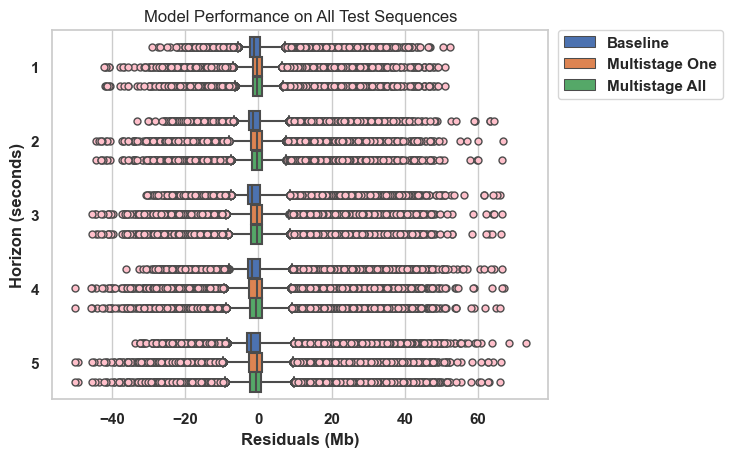

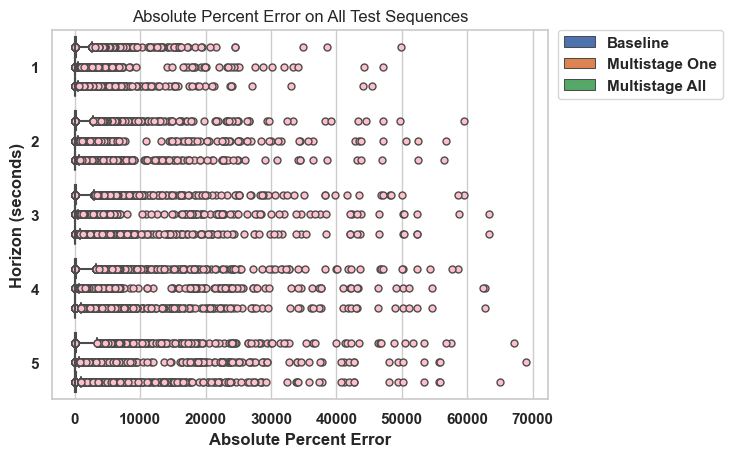

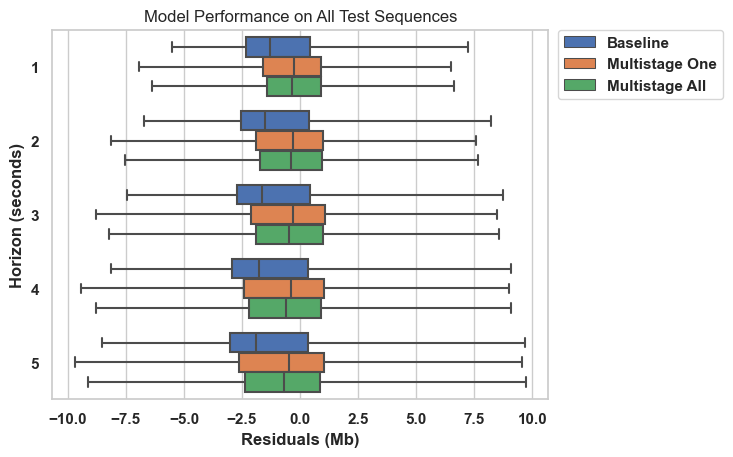

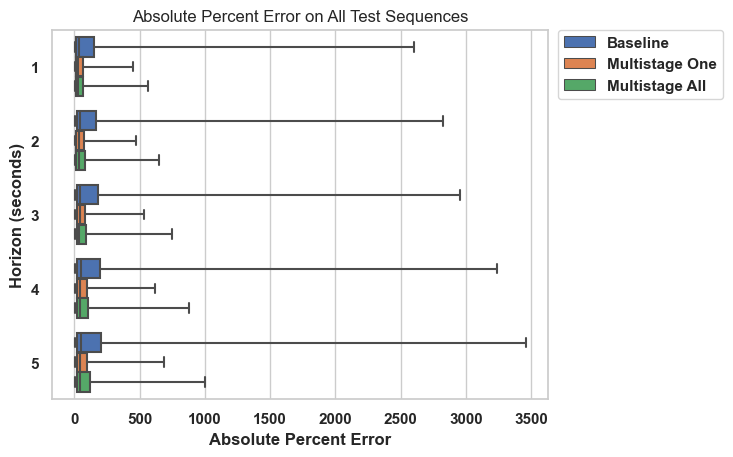

Residuals of All Sequences Test Set
+----------------+----------------------+--------------------+-------------------+--------------------+--------------------+
|     Model      |   Mean Resids (Mb)   |   Resids std (Mb)  |        MAPE       |        MSE         |        MAE         |
+----------------+----------------------+--------------------+-------------------+--------------------+--------------------+
|    Baseline    | -0.6535700967063288  | 5.781580946399066  | 477.6214536537548 | 33853832.111073434 | 3584.073967878944  |
| Multistage One | -0.3483498369716919  | 6.041254477915377  | 199.8780119853645 | 36618103.275850795 | 3384.5552970467065 |
| Multistage All | -0.23868118737583485 | 5.9251854287595425 |  222.048230256022 | 35164791.07439155  | 3263.788805828692  |
+----------------+----------------------+--------------------+-------------------+--------------------+--------------------+
Classification Report:
               precision    recall  f1-score   support

         l

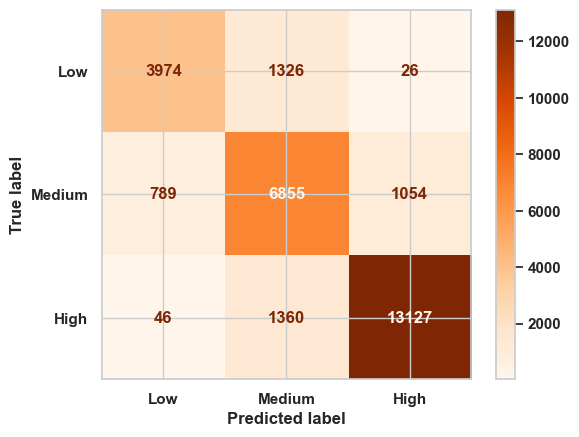

In [24]:
carry_out_analysis("H15H5", "H15H5")

# Individual Models

In [ ]:
true, pred = import_data("balanced_baseline")
base_balanced = get_ts_residuals(true, pred)
mape_balanced = get_mape(true, pred)
ape_balanced = get_ape(true, pred)
true, pred = import_data("pca_selected_baseline")
base = get_ts_residuals(true, pred)
mape = get_mape(true, pred)
ape = get_ape(true, pred)

time_step_boxplots([base, base_balanced], model_names=["Baseline", "Balanced Baseline"], title="Balanced vs Unbalanced")
time_step_boxplots([ape, ape_balanced], model_names=["Baseline", "Balanced Baseline"], title="Balanced vs Unbalanced", xlab="Absolute Percent Error")

In [ ]:
true, pred = import_data("solo_low_all_network")
low = compute_residuals(true, pred)
low_ts = get_ts_residuals(true, pred)
true, pred = import_data("standard_4_all_network_baseline_low")
base_low = compute_residuals(true, pred)
base_low_ts = get_ts_residuals(true, pred)
generate_boxplot(datasets=[base_low, low], xlab=["Baseline", "Low Only"], title="Model Performance on Low Test Sequences", ylim=(-5,5))

In [ ]:
generate_boxplot(datasets=[base_low, low], xlab=["Baseline", "Low Only"], title="Model Performance on Low Test Sequences")

In [ ]:
time_step_boxplots([base_low_ts, low_ts], model_names=["Baseline", "Low Only"], xlim=(-5,5), title="Model Performance on Low Test Sequences")

In [ ]:
base_std = get_std(base_low)
low_std = get_std(low)
table_low = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)"])
table_low.add_row(["Baseline", np.mean(base_low_ts), np.std(base_low_ts)])
table_low.add_row(["Low Only Model", np.mean(low_ts), np.std(low_ts)])
print("Residuals of Low Sequences Test Set")
print(table_low)

In [ ]:
true, pred = import_data("solo_medium_all_network")
medium = compute_residuals(true, pred)
medium_ts = get_ts_residuals(true, pred)
true, pred = import_data("standard_4_all_network_baseline_medium")
base_medium = compute_residuals(true, pred)
base_medium_ts = get_ts_residuals(true, pred)
generate_boxplot(datasets=[base_medium, medium], xlab=["Baseline", "Medium Only"], title="Model Performance on Medium Test Sequences", ylim=(-25,15))

In [ ]:
time_step_boxplots([base_medium_ts, medium_ts], model_names=["Baseline", "Medium Only"], title="Model Performance on Medium Test Sequences")


In [ ]:
base_std = get_std(base_medium_ts)
medium_std = get_std(medium_ts)
table_medium = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)"])
table_medium.add_row(["Baseline",np.mean(base_medium_ts), base_std])
table_medium.add_row(["Medium Only Model",np.mean(medium_ts), medium_std])
print("Residuals of Medium Sequences Test Set")
print(table_medium)

In [ ]:
true, pred = import_data("solo_high_all_network")
high = compute_residuals(true, pred)
high_ts = get_ts_residuals(true, pred)
true, pred = import_data("standard_4_all_network_baseline_high")
base_high = compute_residuals(true, pred)
base_high_ts = get_ts_residuals(true, pred)
generate_boxplot(datasets=[base_high, high], xlab=["Baseline", "High Only"], title="Model Performance on High Test Sequences", ylim=(-40, 40))

In [ ]:
time_step_boxplots([base_high_ts, high_ts], model_names=["Baseline", "High Only"], title="Model Performance on High Test Sequences")


In [ ]:
base_std = get_std(base_high_ts)
high_std = get_std(high_ts)
table_high = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)"])
table_high.add_row(["Baseline",np.mean(base_high_ts), base_std])
table_high.add_row(["High Only Model",np.mean(high_ts), high_std])
print("Residuals of High Sequences Test Set")
print(table_high)

In [ ]:
true, pred = import_data("standardized_multiOne")
multi_one_ts = get_ts_residuals(true, pred)
multi_one_mape = get_mape(true, pred)

true, pred = import_data("standardized_multiAll")
multi_all_ts = get_ts_residuals(true, pred)
multi_all_mape = get_mape(true, pred)

true, pred = import_data("standard_4_all_network_baseline")
base_ts = get_ts_residuals(true, pred)
base_mape = get_mape(true, pred)
# generate_boxplot(datasets=[base, multi_one, multi_all], xlab=["Baseline", "Multistage One", "Multistage All"], title="Model Performance on All Test Sequences")
# generate_boxplot(datasets=[base, multi_one], xlab=["Baseline", "Multistage One"], title="Model Performance on all Test Sequences")

In [ ]:
base_std = get_std(base_ts)
multi_one_std = get_std(multi_one_ts)
multi_all_std = get_std(multi_all_ts)
table = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)", "MAPE"])
table.add_row(["Baseline",np.mean(base_ts), base_std, base_mape])
table.add_row(["Multistage One",np.mean(multi_one_ts), multi_one_std, multi_one_mape])
table.add_row(["Multistage All",np.mean(multi_all_ts), multi_all_std, multi_all_mape])
print("Residuals of All Sequences Test Set")
print(table)

In [ ]:
time_step_boxplots([base_ts, multi_one_ts, multi_all_ts], model_names=["Baseline", "Multistage One", "Multistage All"], title="Model Performance on All Test Sequences", xlim=(-80, 200))


In [ ]:
true, pred = import_data("presentation_2_multiOne")
multi_one_ts = get_ts_residuals(true, pred)
multi_one_mape = get_mape(true, pred)

true, pred = import_data("presentation_2_multiAll")
multi_all_ts = get_ts_residuals(true, pred)
multi_all_mape = get_mape(true, pred)

true_low, pred_low = import_data("standard_4_all_network_baseline_low")
true_low = np.squeeze(true_low)
true_medium, pred_medium = import_data("standard_4_all_network_baseline_medium")
true_medium = np.squeeze(true_medium)
true = np.zeros((len(true_low)+len(true_medium), true_low.shape[1]))
pred = np.zeros((len(pred_low)+len(pred_medium), pred_low.shape[1]))


true[:len(true_low),:] = true_low
true[len(true_low):,:] = true_medium
pred[:len(pred_low),:] = pred_low
pred[len(pred_low):,:] = pred_medium

base_mape = get_mape(true, pred)
base_ts = get_ts_residuals(true, pred)
time_step_boxplots([base_ts, multi_one_ts, multi_all_ts], model_names=["Baseline", "Multistage One", "Multistage All"], title="Model Performance on Med&Low Test Sequences", xlim=(-50,44))


In [ ]:
base_std = get_std(base_ts)
multi_one_std = get_std(multi_one_ts)
multi_all_std = get_std(multi_all_ts)
table = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)", "MAPE"])
table.add_row(["Baseline",np.mean(base), base_std, base_mape])
table.add_row(["Multistage One",np.mean(multi_one), multi_one_std, multi_one_mape])
table.add_row(["Multistage All",np.mean(multi_all), multi_all_std, multi_all_mape])
print("Residuals of Med & Low Sequences Test Set")
print(table)

In [ ]:
print("Residuals of Low Sequences Test Set")
print(table_low)
print("==============================================================\n")
print("Residuals of Medium Sequences Test Set")
print(table_medium)
print("==============================================================\n")
print("Residuals of High Sequences Test Set")
print(table_high)
print("==============================================================")

In [ ]:
true, pred = import_data("solo_all_network_classifier")
print(true)
print(pred)
pred = np.argmax(pred, axis=-1)
print(pred)
conf_matrix = confusion_matrix(true, pred)
display_conf = ConfusionMatrixDisplay(conf_matrix, display_labels=["Low", "Medium", "High"])
display_conf.plot(cmap="Oranges")
plt.show()

In [ ]:
carry_out_analysis(prefix="presentation")